In [41]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# dataset downloading, selecting and reordering columns for further analysis
df=pd.read_excel("cata.xlsx")
df=df.drop(['name','sibsp', 'parch', 'ticket', 'fare', 
                      'cabin', 'embarked', 'boat', 'body', 'home.dest'],axis=1)
df=df[['survived','pclass', 'sex', 'age']]

# checking the dataset for nan and deleting empty rows
df.isna().sum()
df=df.dropna(axis=0)

# formatting the "survived" column into categorical
df = df.astype({'sex':'category', 'survived':'int','pclass':'int','age':'float'})

In [42]:
# the more women and children survived
age=pd.cut(df["age"],[0,18,30,40,80])
df.pivot_table("survived",["sex",age],"pclass")

pclass                  1         2         3
sex    age                                   
female (0, 18]   0.923077  0.952381  0.534483
       (18, 30]  0.972222  0.869565  0.459016
       (30, 40]  0.970588  0.950000  0.428571
       (40, 80]  0.960000  0.812500  0.333333
male   (0, 18]   0.750000  0.523810  0.208333
       (18, 30]  0.375000  0.102941  0.179191
       (30, 40]  0.437500  0.085714  0.161765
       (40, 80]  0.265823  0.058824  0.055556

In [43]:
# the data shows clear evidence of higher chances of survival for the passengers of class1 (pclass)
# although the two groups of survivors: Female&Class1 and Female&Class2 have negligible difference (96% vs 89%)
# the question I'm going to investigate further is whether this difference is statistically significant
df.pivot_table("survived",index="sex",columns="pclass",margins=True)

pclass,1,2,3,All
sex,,,,
female,0.962406,0.893204,0.473684,0.752577
male,0.350993,0.145570,0.169054,0.205167
All,0.637324,0.440613,0.261477,0.408222


In [44]:
# H1 hypothesis - there is a difference in chances to survive between cl1 & cl2
# H0 - there is no difference between these two groups
# to prove H0 I'm going use permutation samples of the empirical dataset

# the function to generate many sets of simulated data assuming H0 is true
def draw_perm_reps(data1,data2,func,size=1):
    perm_replicates=np.empty(size)
    for i in range(size):
        perm_sample1,perm_sample2=permutation_sample(data1,data2)
        perm_replicates[i]=func(perm_sample1,perm_sample2)
    return perm_replicates

In [45]:
# the function to calculcate difference of means
def diff_of_means(data1,data2):
    diff=np.mean(data1)-np.mean(data2)
    return diff

In [46]:
# the function to implement permutation of the sample
def permutation_sample(data1,data2):
    data=np.concatenate((data1,data2))
    permuted_data=np.random.permutation(data)
    perm_sample1=permuted_data[:len(data1)]
    perm_sample2=permuted_data[len(data1):]
    return perm_sample1,perm_sample2

In [47]:
# the code below splits out the two target groups
cl1=df["survived"][(df["sex"]=="female") & (df["pclass"]==1)]
cl1=cl1.values
cl2=df["survived"][(df["sex"]=="female") & (df["pclass"]==2)]
cl2=cl2.values

In [48]:
# calculating empirical difference of means between two datasets (0.07) 
np.random.seed(123)
empirical_diff_means=diff_of_means(cl1,cl2)
print("empirical_diff_means - ",np.round(empirical_diff_means,2))

empirical_diff_means -  0.07


In [49]:
# calculating difference of means for 1000 permutated datasets
perm_replicates=draw_perm_reps(cl1,cl2,diff_of_means,1000)

In [50]:
# p-value is the fraction of the simulated data sets for which 
# the test statistic (difference of means) is at least as extreme as for the empirical dataset
p=np.sum(perm_replicates>=empirical_diff_means)/len(perm_replicates)
print("p-value: ",np.round(p,2))

p-value:  0.03


In [51]:
# p=0.04 - 3% of simulated data has higher than empirical difference of means (7%)
# the results of the statitics let us decline H0 
# and therefore prove H1 - the difference between cl1 and cl2 is statistically significant

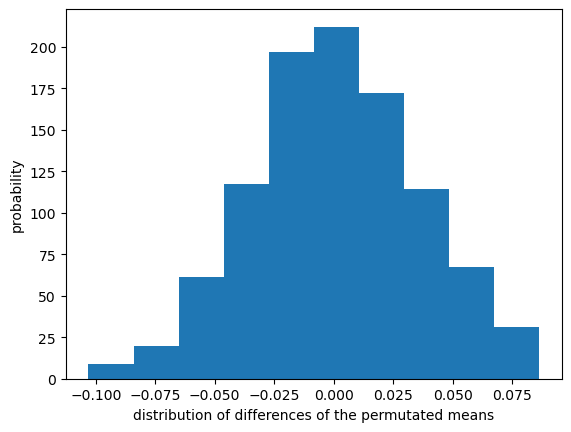

In [52]:
#the chart showing distribution of the permutated means with probability
weights=np.ones_like(perm_replicates/len(perm_replicates))
plt.hist(perm_replicates,weights=weights)
plt.xlabel("distribution of differences of the permutated means")
plt.ylabel("probability")
plt.show()

In [53]:
# although the two groups of survivors: Female&Class1 and Female&Class2 have negligible difference (96% vs 89%)
# the experiment proved that the difference is statistically significant
# which means that Female&Class1 group has higher chances to survive vs Female&Class2 